<a href="https://colab.research.google.com/github/antoniototimorelli/nlp_unibo_2022-23/blob/main/Assignment_1/POS_Fede(daccapo).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nltk
from nltk.corpus import treebank
import numpy as np
import os
import re
import pandas as pd
import seaborn as sns
import urllib.request
import zipfile
import progressbar
import tensorflow
from collections import defaultdict

from gensim.models import KeyedVectors

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Embedding, Dense, TimeDistributed, LSTM, GRU, Bidirectional, SimpleRNN, RNN
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Notebook Fatto per capire il procedimento, non è esatto perchè la divisione non è fatta come chiesto, ma con train_test_split

#1.PreProcess


In [2]:
nltk.download('treebank')
nltk.download('universal_tagset')
treebank_corpus = treebank.tagged_sents()

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [3]:
treebank_corpus[0]

[('Pierre', 'NNP'),
 ('Vinken', 'NNP'),
 (',', ','),
 ('61', 'CD'),
 ('years', 'NNS'),
 ('old', 'JJ'),
 (',', ','),
 ('will', 'MD'),
 ('join', 'VB'),
 ('the', 'DT'),
 ('board', 'NN'),
 ('as', 'IN'),
 ('a', 'DT'),
 ('nonexecutive', 'JJ'),
 ('director', 'NN'),
 ('Nov.', 'NNP'),
 ('29', 'CD'),
 ('.', '.')]

##1.1 Divide in words(X) and tags(Y)

In [4]:
X = []
y = []

for sentence in treebank_corpus:
  X_sentence = []
  y_sentence = []
  for entity in sentence:
    X_sentence.append(entity[0])
    y_sentence.append(entity[1])

  X.append(X_sentence)
  y.append(y_sentence)

In [5]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags = len(set([word.lower() for sentence in y for word in sentence]))

In [6]:
print("Total number of tagged sentences: {}".format(len(X)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))

Total number of tagged sentences: 3914
Vocabulary size: 11387
Total number of tags: 46


In [7]:
# let's look at first data point
# this is one data point that will be fed to the RNN
print('sample X: ', X[0], '\n')
print('sample Y: ', y[0], '\n')

sample X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

sample Y:  ['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.'] 



In [8]:
#Vectorize X and y
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X)
X_encoded = word_tokenizer.texts_to_sequences(X)

In [9]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(y)
y_encoded = tag_tokenizer.texts_to_sequences(y)

In [10]:
# look at first encoded data point

print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X[0], '\n')
print('Y: ', y[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', y_encoded[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

Y:  ['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [5601, 3746, 1, 2024, 86, 331, 1, 46, 2405, 2, 131, 27, 6, 2025, 332, 459, 2026, 3] 

Y:  [3, 3, 8, 10, 6, 7, 8, 21, 13, 4, 1, 2, 4, 7, 1, 3, 10, 9] 



In [11]:
#check lengths

different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded,y_encoded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

0 sentences have disparate input-output lengths.


#1.2 Pad sequences

In [12]:
lengths = [len(seq) for seq in X_sentence]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 8


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


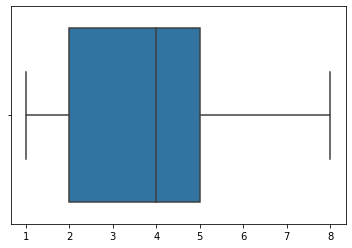

In [13]:
sns.boxplot(lengths)

In [14]:
from IPython.lib.pretty import MAX_SEQ_LENGTH
from tensorflow.keras.preprocessing.sequence import pad_sequences
#Pad each sequence to max_seq_length using keras
#sentences longer than max_seq truncated
#sentences shorter padded with zeroes

# Truncation and padding can either be 'pre' or 'post'. 
# For padding we are using 'pre' padding type, that is, add zeroes on the left side.
# For truncation, we are using 'post', that is, truncate a sentence from right side.

MAX_SEQ_LENGTH = 100

X_padded = pad_sequences(X_encoded, maxlen = MAX_SEQ_LENGTH, padding = 'pre', truncating='post')
y_padded = pad_sequences(y_encoded, maxlen = MAX_SEQ_LENGTH, padding = 'pre', truncating='post')

In [15]:
# print the first sequence
print(X_padded[0], "\n")
print(y_padded[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0 5601 3746
    1 2024   86  331    1   46 2405    2  131   27    6 2025  332  459
 2026    3] 

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  3  3  8 10  6  7  8 21 13  4  1  2  4  7
  1  3 10  9]


In [16]:
X,y = X_padded, y_padded

#2 Word Embeddings


In [17]:
#Use the 300 dimensional GLove Word Embeddings
glove_dir = './'
embedding_dim = 300
vocab_size = len(word_tokenizer.word_index) + 1
embedding_dict = {} #initialize dictionary
f = open(os.path.join(glove_dir, f'glove.6B.{embedding_dim}d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_dict[word] = coefs
f.close()

print('Found %s word vectors.' % len(embedding_dict))
print('Vocab of size %s' % len(embedding_dict))

Found 400000 word vectors.
Vocab of size 400000


In [18]:
embedding_weights = np.zeros((vocab_size,embedding_dim))
word2ind = word_tokenizer.word_index
for word, index in word2ind.items():
  try:
    embedding_weights[index, :] = embedding_dict[word]
  except KeyError:
    pass

In [19]:
print("Embeddings shape: {}".format(embedding_weights.shape))

Embeddings shape: (11388, 300)


In [20]:
from nltk.tokenize import word_tokenize
embedding_weights[word_tokenizer.word_index['bottom']]

array([ 3.61680001e-01,  5.45570016e-01, -4.21449989e-01, -1.32129997e-01,
        1.43869996e-01,  3.33620012e-01, -1.68740004e-01, -1.52049996e-02,
        5.05720019e-01, -1.14370000e+00, -1.26359999e-01, -5.18639982e-02,
       -6.50840029e-02,  3.54719982e-02, -3.45279992e-01,  2.09189996e-01,
       -3.05170000e-01,  3.27719986e-01,  3.66230011e-01, -3.96120012e-01,
       -2.18559995e-01,  2.79549986e-01,  1.25749996e-02, -7.39459991e-02,
       -1.07630000e-01, -2.38110006e-01,  3.42689991e-01,  4.51849997e-01,
        2.59860000e-03,  1.32290006e-01,  1.43790007e-01,  1.45569995e-01,
        4.76429984e-02, -3.54240000e-01, -1.14040005e+00,  4.29199994e-01,
        3.10660005e-01, -1.34020001e-01,  7.56710023e-02,  4.42640007e-01,
        1.20920002e-01,  1.78749993e-01,  4.56500016e-02,  4.57439989e-01,
       -1.56560004e-01,  1.85450003e-01,  2.26889998e-01, -1.55049995e-01,
       -3.61490011e-01,  6.20420016e-02, -1.18060000e-01,  8.91269967e-02,
        1.61850005e-01, -

In [21]:
y = to_categorical(y)

In [22]:
print(y.shape)

(3914, 100, 47)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

In [24]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.25)

In [25]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_val.shape))
print('Shape of output sequences: {}'.format(y_val.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(y_test.shape))

TRAINING DATA
Shape of input sequences: (2201, 100)
Shape of output sequences: (2201, 100, 47)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (734, 100)
Shape of output sequences: (734, 100, 47)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (979, 100)
Shape of output sequences: (979, 100, 47)


In [28]:
# Define the model
baseline_model = Sequential(name='Baseline')

# Add the Embedding layer
# baseline_model.add(Embedding(input_dim=vocab_length, output_dim=embedding_dim, \
#                     weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=False))
baseline_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, \
                    weights=[embedding_weights], input_length=MAX_SEQ_LENGTH, trainable=True))

# Add the Bidirectional LSTM layer
baseline_model.add(Bidirectional(LSTM(units=256, return_sequences=True)))

# Add the Dense/Fully-Connected layer
baseline_model.add(TimeDistributed(Dense(units=47, activation='softmax')))

# Compile the model
baseline_model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
baseline_model.summary()

Model: "Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          3416400   
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 512)         1140736   
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 100, 47)          24111     
 tributed)                                                       
                                                                 
Total params: 4,581,247
Trainable params: 4,581,247
Non-trainable params: 0
_________________________________________________________________


In [29]:
results_baseline = baseline_model.fit(X_train, y_train, validation_data=(X_val, y_val),batch_size=128, epochs=10)

Epoch 1/10
18/18 [==============================] - 6s 94ms/step - loss: 1.7143 - accuracy: 0.7509 - val_loss: 0.6791 - val_accuracy: 0.8365
Epoch 2/10
18/18 [==============================] - 1s 44ms/step - loss: 0.5707 - accuracy: 0.8615 - val_loss: 0.4436 - val_accuracy: 0.8892
Epoch 3/10
18/18 [==============================] - 1s 44ms/step - loss: 0.3678 - accuracy: 0.9102 - val_loss: 0.2881 - val_accuracy: 0.9301
Epoch 4/10
18/18 [==============================] - 1s 44ms/step - loss: 0.2413 - accuracy: 0.9422 - val_loss: 0.1994 - val_accuracy: 0.9522
Epoch 5/10
18/18 [==============================] - 1s 44ms/step - loss: 0.1659 - accuracy: 0.9613 - val_loss: 0.1475 - val_accuracy: 0.9644
Epoch 6/10
18/18 [==============================] - 1s 45ms/step - loss: 0.1198 - accuracy: 0.9719 - val_loss: 0.1160 - val_accuracy: 0.9722
Epoch 7/10
18/18 [==============================] - 1s 44ms/step - loss: 0.0901 - accuracy: 0.9789 - val_loss: 0.0956 - val_accuracy: 0.9765
Epoch 8/10
18

In [30]:
scores = baseline_model.evaluate(X_test, y_test, return_dict = True)

31/31 [==============================] - 0s 8ms/step - loss: 0.0670 - accuracy: 0.9820


In [31]:
predictions = baseline_model.predict(X_test)

31/31 [==============================] - 1s 7ms/step


In [32]:
from sklearn.metrics import f1_score
# Flatten the predictions and the true labels to 1D arrays
predictions = predictions.flatten()
y_true = y_test.flatten()

th = 0.1
predictions[predictions >= th] = 1 
predictions[predictions  < th] = 0

# Compute the F1 score
f1_baseline = f1_score(y_true, predictions, average = 'macro')

print("Macro-F1 score:", round(f1_baseline,3))

baseline_model.save('./baseline_model')

Macro-F1 score: 0.984


#GRU



In [33]:
# Define the model
gru_model = tensorflow.keras.Sequential(name='GRU')

# Add the Embedding layer
gru_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, \
                    weights = [embedding_weights], input_length = MAX_SEQ_LENGTH, trainable=True))

# Add the GRU layer
gru_model.add(GRU(units=128, return_sequences=True))

# Add the Dense/Fully-Connected layer
gru_model.add(TimeDistributed(Dense(47, activation='softmax')))

# Compile the model
gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
gru_model.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          3416400   
                                                                 
 gru (GRU)                   (None, 100, 128)          165120    
                                                                 
 time_distributed_2 (TimeDis  (None, 100, 47)          6063      
 tributed)                                                       
                                                                 
Total params: 3,587,583
Trainable params: 3,587,583
Non-trainable params: 0
_________________________________________________________________


In [34]:
results_gru = gru_model.fit(X_train, y_train, epochs=10, verbose = True, validation_data=(X_val,y_val), batch_size=128)

Epoch 1/10
18/18 [==============================] - 3s 44ms/step - loss: 3.0055 - accuracy: 0.7902 - val_loss: 1.0743 - val_accuracy: 0.7600
Epoch 2/10
18/18 [==============================] - 0s 16ms/step - loss: 0.8249 - accuracy: 0.8184 - val_loss: 0.6529 - val_accuracy: 0.8655
Epoch 3/10
18/18 [==============================] - 0s 16ms/step - loss: 0.5744 - accuracy: 0.8767 - val_loss: 0.4860 - val_accuracy: 0.8953
Epoch 4/10
18/18 [==============================] - 0s 16ms/step - loss: 0.4292 - accuracy: 0.9126 - val_loss: 0.3697 - val_accuracy: 0.9249
Epoch 5/10
18/18 [==============================] - 0s 15ms/step - loss: 0.3255 - accuracy: 0.9347 - val_loss: 0.2882 - val_accuracy: 0.9404
Epoch 6/10
18/18 [==============================] - 0s 16ms/step - loss: 0.2511 - accuracy: 0.9490 - val_loss: 0.2304 - val_accuracy: 0.9513
Epoch 7/10
18/18 [==============================] - 0s 16ms/step - loss: 0.1969 - accuracy: 0.9600 - val_loss: 0.1888 - val_accuracy: 0.9598
Epoch 8/10
18

In [35]:
y_pred = gru_model.predict(X_test)
# Flatten the predictions and the true labels to 1D arrays
predictions = y_pred.flatten()
y_true = y_test.flatten()

th = 0.1
predictions[predictions >= th] = 1 
predictions[predictions  < th] = 0

# Compute the F1 score
f1_gru = f1_score(y_true, predictions, average = 'macro')

print("Macro-F1 score:", round(f1_gru,3))

gru_model.save('./gru_model')

31/31 [==============================] - 0s 3ms/step
Macro-F1 score: 0.975


#Additional LSTM Layer

In [36]:
# Define the model
add_lstm_model = tensorflow.keras.Sequential(name='Additional_LSTM')

# Add the Embedding layer
add_lstm_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, \
                    weights = [embedding_weights], input_length = MAX_SEQ_LENGTH, trainable=True))

# Add the Bidirectional LSTM layer
add_lstm_model.add(Bidirectional(LSTM(units=128, return_sequences=True)))

# Add another LSTM layer
add_lstm_model.add(Bidirectional(LSTM(units=128, return_sequences=True)))

# Add the Dense/Fully-Connected layer
add_lstm_model.add(TimeDistributed(Dense(units=47, activation='softmax')))

# Compile the model
add_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
add_lstm_model.summary()

Model: "Additional_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 300)          3416400   
                                                                 
 bidirectional_2 (Bidirectio  (None, 100, 256)         439296    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 100, 256)         394240    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 100, 47)          12079     
 tributed)                                                       
                                                                 
Total params: 4,262,015
Trainable params: 4,262,015
Non-trainable params: 0
_________________________________________

In [37]:
results_add_lstm = add_lstm_model.fit(X_train, y_train, epochs=15, verbose = True, validation_data=(X_val,y_val), batch_size=128)

Epoch 1/15
18/18 [==============================] - 9s 132ms/step - loss: 1.8430 - accuracy: 0.7216 - val_loss: 0.8052 - val_accuracy: 0.7733
Epoch 2/15
18/18 [==============================] - 1s 46ms/step - loss: 0.7760 - accuracy: 0.7827 - val_loss: 0.7375 - val_accuracy: 0.7916
Epoch 3/15
18/18 [==============================] - 1s 46ms/step - loss: 0.7085 - accuracy: 0.8101 - val_loss: 0.6484 - val_accuracy: 0.8341
Epoch 4/15
18/18 [==============================] - 1s 46ms/step - loss: 0.5860 - accuracy: 0.8541 - val_loss: 0.4947 - val_accuracy: 0.8816
Epoch 5/15
18/18 [==============================] - 1s 46ms/step - loss: 0.4260 - accuracy: 0.8963 - val_loss: 0.3495 - val_accuracy: 0.9152
Epoch 6/15
18/18 [==============================] - 1s 46ms/step - loss: 0.2975 - accuracy: 0.9287 - val_loss: 0.2499 - val_accuracy: 0.9411
Epoch 7/15
18/18 [==============================] - 1s 46ms/step - loss: 0.2084 - accuracy: 0.9521 - val_loss: 0.1832 - val_accuracy: 0.9607
Epoch 8/15
1

In [38]:
y_pred = add_lstm_model.predict(X_test)
# Flatten the predictions and the true labels to 1D arrays
predictions = y_pred.flatten()
y_true = y_test.flatten()

th = 0.1
predictions[predictions >= th] = 1 
predictions[predictions  < th] = 0

# Compute the F1 score
f1_add_lstm = f1_score(y_true, predictions, average = 'macro')

print("Macro-F1 score:", round(f1_add_lstm,3))

add_lstm_model.save('./add_lstm_model')

31/31 [==============================] - 2s 24ms/step
Macro-F1 score: 0.985


#Additional Dense Layer

In [39]:
# Define the model
add_fc_model = tensorflow.keras.Sequential(name='Additional_FC')

# Add the Embedding layer
add_fc_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, \
                    weights = [embedding_weights], input_length = MAX_SEQ_LENGTH, trainable=True))

# Add the Bidirectional LSTM layer
add_fc_model.add(Bidirectional(LSTM(units=128, return_sequences=True)))

# Add another Dense layer
add_fc_model.add(TimeDistributed(Dense(units=MAX_SEQ_LENGTH, activation='relu')))

# Add the Dense/Fully-Connected layer
add_fc_model.add(TimeDistributed(Dense(units=47, activation='softmax')))

# Compile the model
add_fc_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
add_fc_model.summary()

Model: "Additional_FC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 300)          3416400   
                                                                 
 bidirectional_4 (Bidirectio  (None, 100, 256)         439296    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 100, 100)         25700     
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 100, 47)          4747      
 tributed)                                                       
                                                                 
Total params: 3,886,143
Trainable params: 3,886,143
Non-trainable params: 0
___________________________________________

In [40]:
results_add_fc = add_fc_model.fit(X_train, y_train, epochs=15, verbose = True, validation_data=(X_val,y_val), batch_size=128)

Epoch 1/15
18/18 [==============================] - 4s 80ms/step - loss: 2.2887 - accuracy: 0.7184 - val_loss: 0.8363 - val_accuracy: 0.7845
Epoch 2/15
18/18 [==============================] - 0s 28ms/step - loss: 0.7396 - accuracy: 0.8152 - val_loss: 0.6365 - val_accuracy: 0.8549
Epoch 3/15
18/18 [==============================] - 1s 29ms/step - loss: 0.5688 - accuracy: 0.8641 - val_loss: 0.4744 - val_accuracy: 0.8838
Epoch 4/15
18/18 [==============================] - 0s 28ms/step - loss: 0.4067 - accuracy: 0.8987 - val_loss: 0.3307 - val_accuracy: 0.9188
Epoch 5/15
18/18 [==============================] - 1s 29ms/step - loss: 0.2769 - accuracy: 0.9338 - val_loss: 0.2283 - val_accuracy: 0.9452
Epoch 6/15
18/18 [==============================] - 1s 28ms/step - loss: 0.1874 - accuracy: 0.9564 - val_loss: 0.1647 - val_accuracy: 0.9611
Epoch 7/15
18/18 [==============================] - 1s 28ms/step - loss: 0.1306 - accuracy: 0.9698 - val_loss: 0.1262 - val_accuracy: 0.9692
Epoch 8/15
18

In [41]:
y_pred = add_fc_model.predict(X_test)
# Flatten the predictions and the true labels to 1D arrays
predictions = y_pred.flatten()
y_true = y_test.flatten()

th = 0.1
predictions[predictions >= th] = 1 
predictions[predictions  < th] = 0

# Compute the F1 score
f1_add_fc = f1_score(y_true, predictions, average = 'macro')

print("Macro-F1 score:", round(f1_add_fc,3))

add_fc_model.save('./add_fc_model')

31/31 [==============================] - 1s 6ms/step
Macro-F1 score: 0.986


In [42]:
import plotly.express as px
import plotly.graph_objects as go

# # Create a list of epochs (i.e., the x-axis data)
epochs = list(range(1, len(results_baseline.history['val_accuracy'])+1))

# # Create a Plotly line plot using the epochs and validation accuracy data
fig = go.Figure()
fig.add_trace(go.Scatter(x=epochs, y=results_baseline.history['val_accuracy'], name='Baseline - BiLSTM Model', mode='lines+markers'))
fig.add_trace(go.Scatter(x=epochs, y=results_gru.history['val_accuracy'], name='GRU Model', mode='lines+markers'))
fig.show()

# Create a list of epochs (i.e., the x-axis data)
epochs = list(range(1, len(results_add_lstm.history['val_accuracy'])+1))

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=epochs, y=results_add_lstm.history['val_accuracy'], name='2 BiLSTMs Model', mode='lines+markers'))
fig2.add_trace(go.Scatter(x=epochs, y=results_add_fc.history['val_accuracy'], name='2 FCs Model', mode='lines+markers'))
fig2.show()

max_width = max(len(str(f1_baseline)), len(str(f1_gru)), len(str(f1_add_lstm)), len(str(f1_add_fc)))

header_row = f'| F1 Score Baseline {" " * (max_width - len("F1 Score Baseline"))} | F1 Score GRU {" " * (max_width - len("F1 Score GRU"))} |\
 F1 Score Add. BiLSTM {" " * (max_width - len("F1 Score Add. BiLSTM"))} | F1 Score Add. Dense {" " * (max_width - len("F1 Score Add. Dense"))} |'
separator_row = '-' * len(header_row)
data_row = f'| {f1_baseline:<{max_width}} | {f1_gru:<{max_width}} | {f1_add_lstm:<{max_width}} | {f1_add_fc:<{max_width}} |'

print(header_row)
print(separator_row)
print(data_row)

| F1 Score Baseline   | F1 Score GRU        | F1 Score Add. BiLSTM  | F1 Score Add. Dense  |
--------------------------------------------------------------------------------------------
| 0.9836321274537105 | 0.9751587602930509 | 0.9852040049235016 | 0.9858732543780686 |
